In [1]:
import pandas as pd


In [2]:
import re
from pathlib import Path
import pandas as pd

def load_results(func_name: str,
                 base_dir: str = '.') -> pd.DataFrame:
    base = Path(base_dir) / func_name
    if not base.is_dir():
        raise FileNotFoundError(f"{base!s} is not a directory")

    dfs = []
    for kernel_dir in base.iterdir():
        if not kernel_dir.is_dir():
            continue
        kernel = kernel_dir.name
        # look for files ending in "_seed<digits>.csv"
        pattern = f"{func_name}_{kernel}_seed*.csv"
        for csv_path in kernel_dir.glob(pattern):
            stem = csv_path.stem
            # regex finds last "_seed" followed by digits
            m = re.search(r'_(?:seed)?(\d+)$', stem)
            if not m:
                # no trailing digits → skip
                continue
            seed = int(m.group(1))
            df = pd.read_csv(csv_path)
            df['kernel'] = kernel
            df['seed']   = seed
            dfs.append(df)

    if not dfs:
        raise FileNotFoundError(f"No CSVs matching pattern under {base!s}")

    return pd.concat(dfs, ignore_index=True)


In [3]:
res = load_results(func_name='Rosenbrock100', base_dir='./results')

/tmp/ipykernel_3580202/966805311.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap    = get_cmap('tab10')


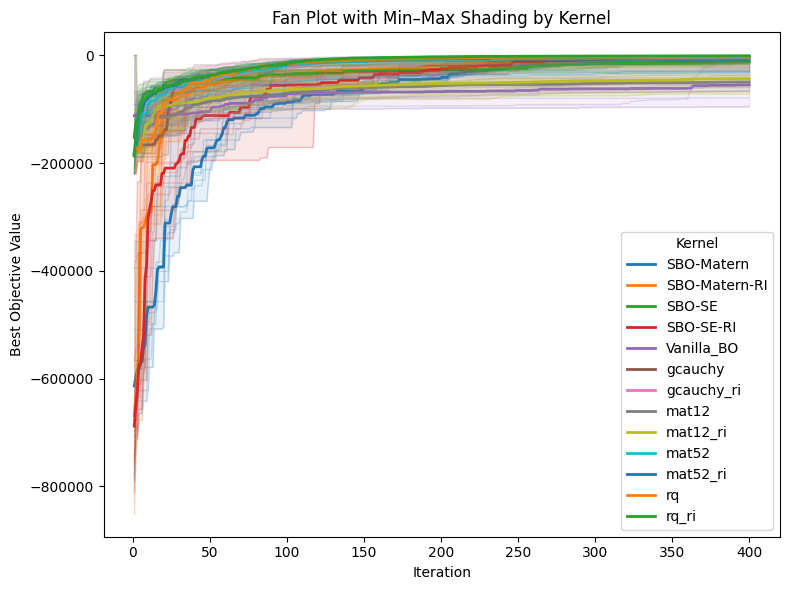

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

#res = pd.read_csv('rbrock50.csv')
#res = pd.read_csv('stybtang200.csv')
res.sort_values(['kernel','seed','iteration'], inplace=True)
res['best_obj'] = res.groupby(['kernel','seed'])['best_obj_val'].cummax()

kernels = res['kernel'].unique()
cmap    = get_cmap('tab10')
colors  = {k:cmap(i%10) for i,k in enumerate(kernels)}

fig,ax = plt.subplots(figsize=(8,6))
for k in kernels:
    dfk = res[res['kernel']==k]
    # plot each seed faintly
    for _,run in dfk.groupby('seed'):
        ax.plot(run.iteration, run.best_obj,
                color=colors[k], alpha=0.2, linewidth=1)
    # compute min, median, max across seeds at each iteration
    agg = ( dfk.groupby('iteration')['best_obj']
             .agg(['min','median','max']) )
    # shade between min and max
    ax.fill_between(agg.index, agg['min'], agg['max'],
                    color=colors[k], alpha=0.1)
    # plot median
    ax.plot(agg.index, agg['median'],
            color=colors[k], linewidth=2, label=str(k))

ax.set(xlabel='Iteration', ylabel='Best Objective Value',
       title='Fan Plot with Min–Max Shading by Kernel')
ax.legend(title='Kernel', loc='best')
plt.tight_layout()
plt.show()

/tmp/ipykernel_3580202/216464564.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap  = get_cmap('tab10')


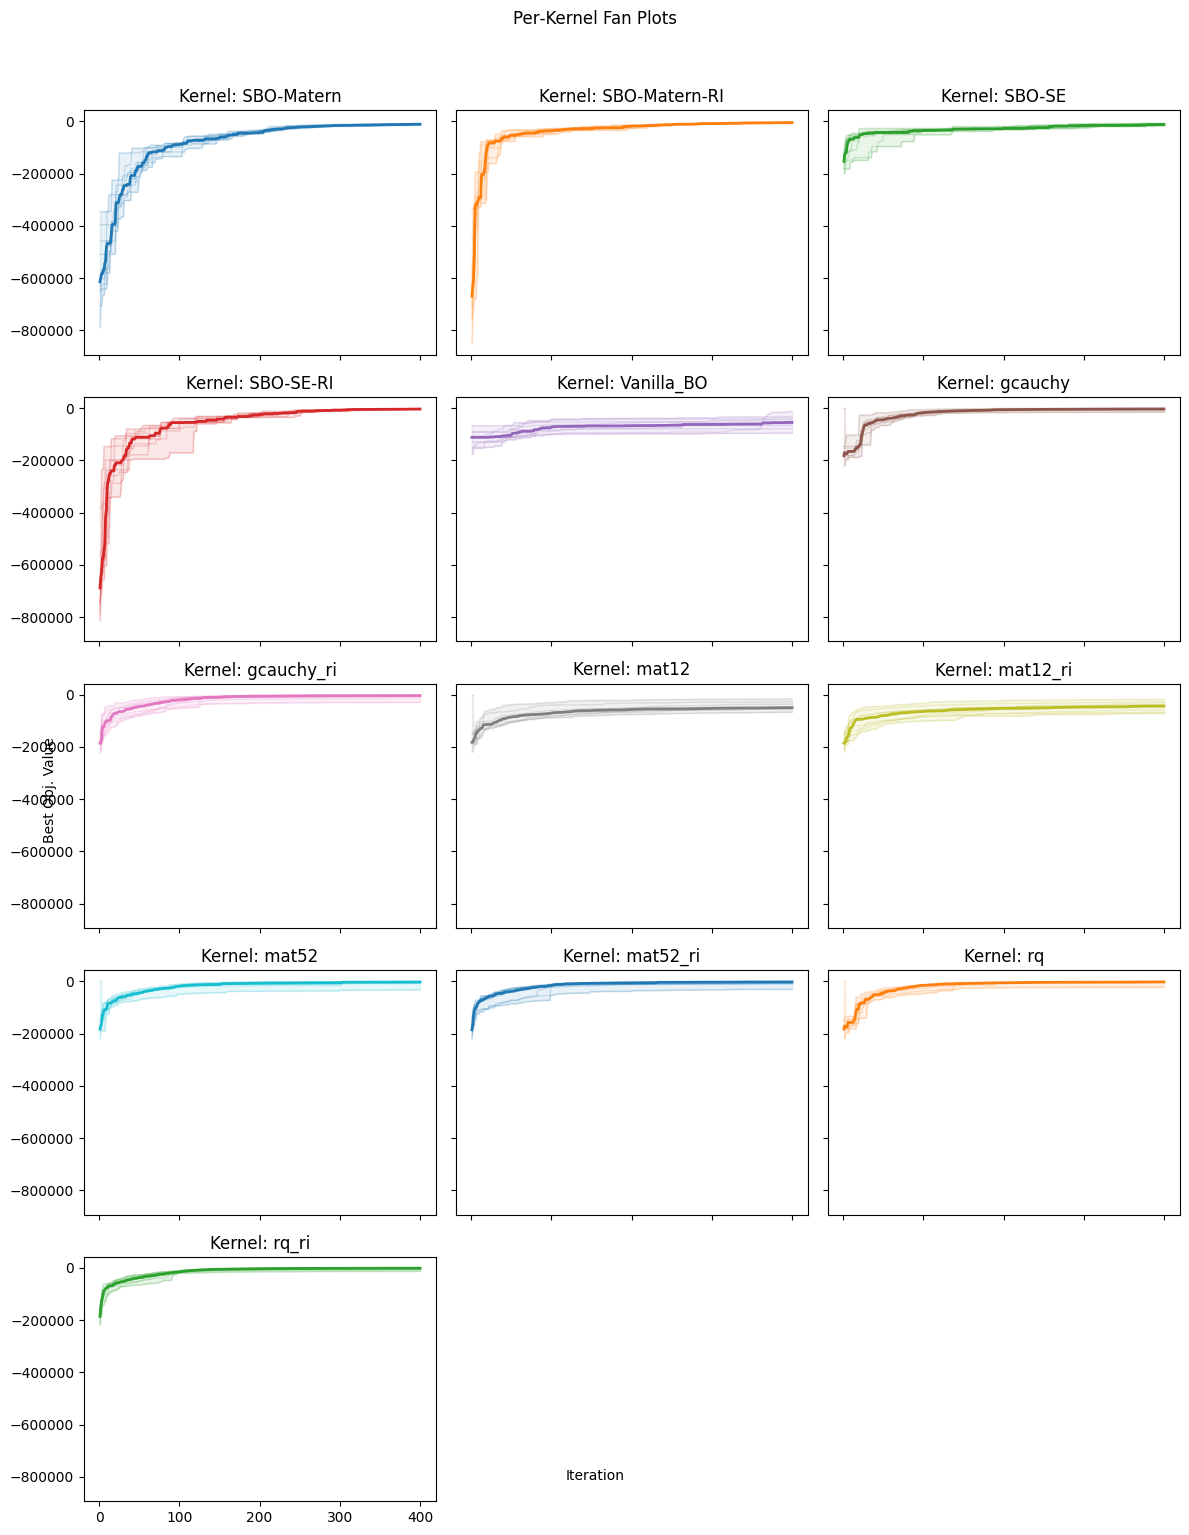

In [5]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# load & preprocess as before
#res = pd.read_csv('stybtang200.csv')
res.sort_values(['kernel','seed','iteration'], inplace=True)
res['best_obj'] = res.groupby(['kernel','seed'])['best_obj_val'].cummax()

# identify kernels & grid shape
kernels = sorted(res['kernel'].unique())
n_k = len(kernels)
ncols = 3                      
nrows = math.ceil(n_k / ncols)

# colormap
cmap  = get_cmap('tab10')
colors = {k: cmap(i % 10) for i,k in enumerate(kernels)}

# make subplots
fig, axes = plt.subplots(nrows, ncols,
                         sharex=True, sharey=True,
                         figsize=(4*ncols, 3*nrows))
axes = axes.flatten()

# loop kernels → each axis
for ax, k in zip(axes, kernels):
    dfk = res[res['kernel']==k]
    # faint individual runs
    for _, run in dfk.groupby('seed'):
        ax.plot(run.iteration, run.best_obj,
                color=colors[k], alpha=0.2, lw=1)
    # aggregate
    agg = dfk.groupby('iteration')['best_obj'].agg(['min','median','max'])
    # shade
    ax.fill_between(agg.index, agg['min'], agg['max'],
                    color=colors[k], alpha=0.1)
    # median line
    ax.plot(agg.index, agg['median'],
            color=colors[k], lw=2)
    ax.set_title(f'Kernel: {k}')

# turn off any empty subplots
for ax in axes[n_k:]:
    ax.axis('off')

# global labels
fig.text(0.5, 0.04, 'Iteration', ha='center')
fig.text(0.04, 0.5, 'Best Obj. Value', va='center', rotation='vertical')
fig.suptitle('Per‐Kernel Fan Plots', y=1.02)
plt.tight_layout()
plt.show()


/tmp/ipykernel_3580202/2771175738.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap    = get_cmap('tab10')
/tmp/ipykernel_3580202/2771175738.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


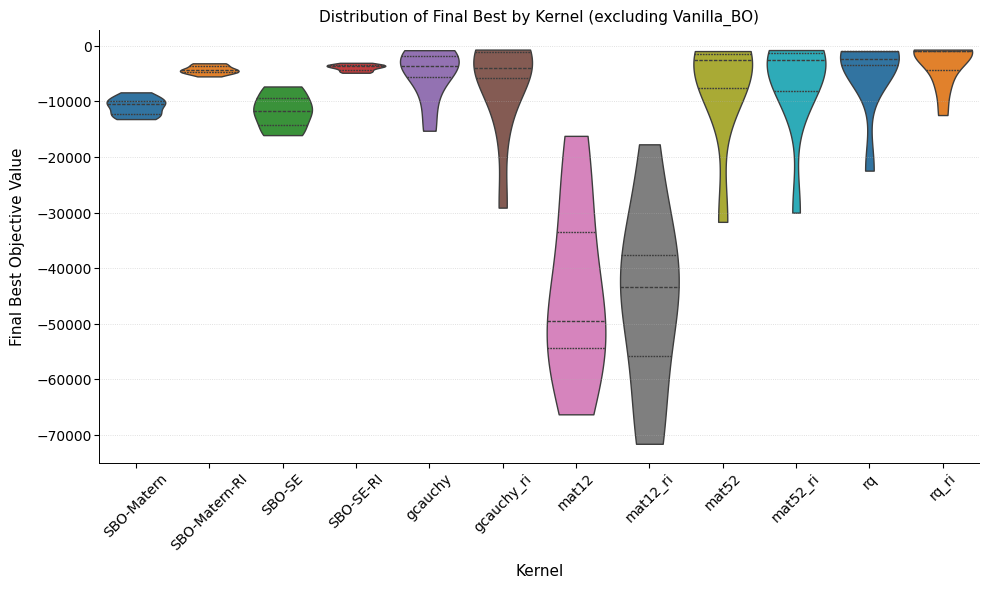

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.cm import get_cmap

mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
    'font.size': 11,
    'axes.labelsize': 11,
    'axes.titlesize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 11
})

res.sort_values(['kernel','seed','iteration'], inplace=True)
res['best_obj'] = res.groupby(['kernel','seed'])['best_obj_val'].cummax()

final_best = (
    res[res['iteration'] == res['iteration'].max()]
       .groupby(['kernel','seed'], as_index=False)['best_obj']
       .last()
)

final_best = final_best[final_best['kernel'] != 'Vanilla_BO']

kernels = sorted(final_best['kernel'].unique())
cmap    = get_cmap('tab10')
palette = {k: cmap(i % 10) for i,k in enumerate(kernels)}

fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(
    data=final_best,
    x='kernel',
    y='best_obj',
    order=kernels,
    palette=[palette[k] for k in kernels],
    inner='quartile',
    linewidth=1.0,
    cut=0,
    ax=ax
)

ax.set_xlabel('Kernel', labelpad=8)
ax.set_ylabel('Final Best Objective Value', labelpad=8)
ax.set_title('Distribution of Final Best by Kernel (excluding Vanilla_BO)')

ax.tick_params(axis='x', rotation=45, pad=2)
ax.tick_params(axis='y', pad=2)

ax.grid(axis='y', linestyle=':', alpha=0.5, linewidth=0.6)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(0.7)

plt.tight_layout(pad=1)
plt.show()